In [1]:
!pip install tensorflow


In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [49]:
dataset = pd.read_csv('AAPL.csv')

In [50]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10468.000000,10468.000000,10468.000000,10468.000000,10468.000000,1.046800e+04
mean,14.757987,14.921491,14.594484,14.763533,14.130431,3.308489e+08
std,31.914174,32.289158,31.543959,31.929489,31.637275,3.388418e+08
min,0.049665,0.049665,0.049107,0.049107,0.038329,0.000000e+00
25%,0.283482,0.289286,0.276786,0.283482,0.235462,1.237768e+08
50%,0.474107,0.482768,0.465960,0.475446,0.392373,2.181592e+08
75%,14.953303,15.057143,14.692589,14.901964,12.835269,4.105794e+08
max,182.630005,182.940002,179.119995,182.009995,181.511703,7.421641e+09


In [51]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10468 entries, 0 to 10467
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10468 non-null  object 
 1   Open       10468 non-null  float64
 2   High       10468 non-null  float64
 3   Low        10468 non-null  float64
 4   Close      10468 non-null  float64
 5   Adj Close  10468 non-null  float64
 6   Volume     10468 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 572.6+ KB


In [52]:
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600


In [53]:
dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10463,2022-06-13,132.869995,135.199997,131.440002,131.880005,131.880005,122207100
10464,2022-06-14,133.130005,133.889999,131.479996,132.759995,132.759995,84784300
10465,2022-06-15,134.289993,137.339996,132.160004,135.429993,135.429993,91533000
10466,2022-06-16,132.080002,132.389999,129.039993,130.059998,130.059998,108123900
10467,2022-06-17,130.070007,133.080002,129.809998,131.559998,131.559998,134118500


In [54]:
# Preprocess the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset['Close'].values.reshape(-1, 1))


In [55]:
# Preprocess the data
scaler = MinMaxScaler()
dataset['Close'] = scaler.fit_transform(dataset['Close'].values.reshape(-1, 1))


In [56]:
# Separate features and target variable
x = dataset.drop('Close', axis=1).values

y = dataset['Close'].values

In [57]:
# Split the data into training and test sets
train_size = int(len(dataset) * 0.8)
train_data = dataset[:train_size]
test_data = dataset[train_size:]

# Define the number of previous days to use for prediction
window_size = 10



In [58]:
# Function to create sliding windows
def create_windows(data, window_size):
    X = []
    y = []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size]
        X.append(window[:-1])
        y.append([data[i+window_size]])  # Convert y to a 2D array
    return np.array(X), np.array(y)




In [59]:
# Create input and output windows for training and test sets
X_train, y_train = create_windows(train_data['Close'].values, window_size)
X_test, y_test = create_windows(test_data['Close'].values, window_size)


In [61]:
print(X_train)
print(X_test)

[[0.00043548 0.00039868 0.00034961 ... 0.00045695 0.00048762 0.00052749]
 [0.00039868 0.00034961 0.00036495 ... 0.00048762 0.00052749 0.00060109]
 [0.00034961 0.00036495 0.00038335 ... 0.00052749 0.00060109 0.00061336]
 ...
 [0.10032277 0.10173006 0.10355738 ... 0.10650149 0.10689405 0.10520216]
 [0.10173006 0.10355738 0.10492542 ... 0.10689405 0.10520216 0.10398133]
 [0.10355738 0.10492542 0.10491756 ... 0.10520216 0.10398133 0.10282331]]
[[0.10127275 0.1032983  0.10301763 ... 0.10390282 0.10384198 0.1039362 ]
 [0.1032983  0.10301763 0.10331597 ... 0.10384198 0.1039362  0.10495092]
 [0.10301763 0.10331597 0.103999   ... 0.1039362  0.10495092 0.10505299]
 ...
 [0.8169937  0.83073292 0.79869306 ... 0.78363484 0.75335364 0.72450129]
 [0.83073292 0.79869306 0.80286975 ... 0.75335364 0.72450129 0.72933744]
 [0.79869306 0.80286975 0.8169937  ... 0.72450129 0.72933744 0.74401091]]


In [62]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
# Apply Recursive feature Elimination

lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=5)
X_train_rfe = rfe.fit_transform(X_train, y_train)
X_test_rfe = rfe.transform(X_test)


In [63]:
print(X_train_rfe)
print(X_test_rfe)

[[0.00043548 0.00034961 0.00045695 0.00048762 0.00052749]
 [0.00039868 0.00036495 0.00048762 0.00052749 0.00060109]
 [0.00034961 0.00038335 0.00052749 0.00060109 0.00061336]
 ...
 [0.10032277 0.10355738 0.10650149 0.10689405 0.10520216]
 [0.10173006 0.10492542 0.10689405 0.10520216 0.10398133]
 [0.10355738 0.10491756 0.10520216 0.10398133 0.10282331]]
[[0.10127275 0.10301763 0.10390282 0.10384198 0.1039362 ]
 [0.1032983  0.10331597 0.10384198 0.1039362  0.10495092]
 [0.10301763 0.103999   0.1039362  0.10495092 0.10505299]
 ...
 [0.8169937  0.79869306 0.78363484 0.75335364 0.72450129]
 [0.83073292 0.80286975 0.75335364 0.72450129 0.72933744]
 [0.79869306 0.8169937  0.72450129 0.72933744 0.74401091]]


In [66]:
# Apply Principal Component Analysis (PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_rfe)
X_test_pca = pca.transform(X_test_rfe)


In [67]:
print(X_train_pca)
print(X_test_pca)

[[-4.20250364e-02 -9.01971883e-05  9.76470585e-05]
 [-4.19696772e-02 -1.84935764e-04  7.03531637e-05]
 [-4.18980190e-02 -2.42160726e-04  2.90418246e-05]
 ...
 [ 2.70254050e-01 -5.00842003e-03 -2.78442558e-03]
 [ 2.71468970e-01 -2.03696984e-03 -3.55620559e-03]
 [ 2.71828410e-01  1.12307301e-03 -3.79729149e-03]]
[[ 2.66969698e-01 -1.35517253e-03 -1.13874082e-03]
 [ 2.68194592e-01 -7.69378085e-04 -9.53794456e-05]
 [ 2.68779930e-01 -1.01803350e-03  1.66149363e-04]
 ...
 [ 2.33679089e+00  8.14957363e-02 -4.15245372e-02]
 [ 2.30754156e+00  1.01555071e-01 -3.81387589e-02]
 [ 2.27864665e+00  9.65211046e-02 -1.61282765e-02]]


In [68]:
# Reshape the data for LSTM
X_train_lstm = X_train_pca.reshape((X_train_pca.shape[0], X_train_pca.shape[1], 1))
X_test_lstm = X_test_pca.reshape((X_test_pca.shape[0], X_test_pca.shape[1], 1))
print(X_train_lstm)
print(X_test_lstm)


[[[-4.20250364e-02]
  [-9.01971883e-05]
  [ 9.76470585e-05]]

 [[-4.19696772e-02]
  [-1.84935764e-04]
  [ 7.03531637e-05]]

 [[-4.18980190e-02]
  [-2.42160726e-04]
  [ 2.90418246e-05]]

 ...

 [[ 2.70254050e-01]
  [-5.00842003e-03]
  [-2.78442558e-03]]

 [[ 2.71468970e-01]
  [-2.03696984e-03]
  [-3.55620559e-03]]

 [[ 2.71828410e-01]
  [ 1.12307301e-03]
  [-3.79729149e-03]]]
[[[ 2.66969698e-01]
  [-1.35517253e-03]
  [-1.13874082e-03]]

 [[ 2.68194592e-01]
  [-7.69378085e-04]
  [-9.53794456e-05]]

 [[ 2.68779930e-01]
  [-1.01803350e-03]
  [ 1.66149363e-04]]

 ...

 [[ 2.33679089e+00]
  [ 8.14957363e-02]
  [-4.15245372e-02]]

 [[ 2.30754156e+00]
  [ 1.01555071e-01]
  [-3.81387589e-02]]

 [[ 2.27864665e+00]
  [ 9.65211046e-02]
  [-1.61282765e-02]]]


In [69]:
import numpy as np

# Reshape X_train_lstm
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], 1, X_train_lstm.shape[1]))


In [70]:
print(X_train_lstm)

[[[-4.20250364e-02 -9.01971883e-05  9.76470585e-05]]

 [[-4.19696772e-02 -1.84935764e-04  7.03531637e-05]]

 [[-4.18980190e-02 -2.42160726e-04  2.90418246e-05]]

 ...

 [[ 2.70254050e-01 -5.00842003e-03 -2.78442558e-03]]

 [[ 2.71468970e-01 -2.03696984e-03 -3.55620559e-03]]

 [[ 2.71828410e-01  1.12307301e-03 -3.79729149e-03]]]


In [71]:

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM

import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=25, verbose=1)
history_model_lstm = model_lstm.fit(X_train_lstm, y_train, epochs=100, batch_size=50, verbose=1, shuffle=False, callbacks=[early_stop])


Epoch 1/100
168/168 [==============================] - 3s 3ms/step - loss: 1.3476e-04
Epoch 2/100
168/168 [==============================] - 1s 3ms/step - loss: 9.8551e-04
Epoch 3/100
168/168 [==============================] - 1s 3ms/step - loss: 5.9766e-04
Epoch 4/100
168/168 [==============================] - 1s 3ms/step - loss: 4.2391e-04
Epoch 5/100
168/168 [==============================] - 1s 3ms/step - loss: 2.7007e-04
Epoch 6/100
168/168 [==============================] - 1s 3ms/step - loss: 1.4681e-04
Epoch 7/100
168/168 [==============================] - 1s 3ms/step - loss: 6.6538e-05
Epoch 8/100
168/168 [==============================] - 1s 3ms/step - loss: 2.6499e-05
Epoch 9/100
168/168 [==============================] - 1s 3ms/step - loss: 1.0986e-05
Epoch 10/100
168/168 [==============================] - 1s 3ms/step - loss: 5.5934e-06
Epoch 11/100
168/168 [==============================] - 0s 3ms/step - loss: 3.7631e-06
Epoch 12/100
168/168 [==============================

In [72]:
from sklearn.metrics import r2_score

X_test_lstm = np.transpose(X_test_lstm, (0, 2, 1))
y_pred_test_lstm = model_lstm.predict(X_test_lstm)

#y_pred_test_lstm = model_lstm.predict(X_test_lstm)
y_train_pred_lstm = model_lstm.predict(X_train_lstm)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)



262/262 [==============================] - 1s 2ms/step
The R2 score on the Train set is:	0.996
The R2 score on the Test set is:	0.957


In [73]:
score_lstm= model_lstm.evaluate(X_test_lstm, y_test, batch_size=1)

2084/2084 [==============================] - 5s 2ms/step - loss: 0.0027


In [74]:
print('LSTM: %f'%score_lstm)

LSTM: 0.002717


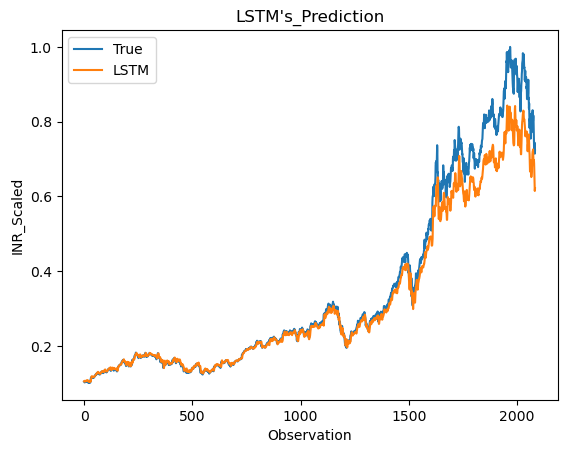

In [75]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()


In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train(model, model_name):
    model.fit(X_train_lstm, y_train)
    
    # Reshape the input data
    print("X_test_lstm shape:", X_test_lstm.shape)
    print("X_train_lstm shape:", X_train_lstm.shape)
    X_test_lstm_reshaped = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_train_lstm.shape[1], X_train_lstm.shape[2]))
    print("X_test_lstm_reshaped shape:", X_test_lstm_reshaped.shape)
    
    # Calculate predictions
    y_pred = model.predict(X_test_lstm_reshaped)
    
    # Flatten the predictions and actual values
    y_pred = y_pred.flatten()
    y_test_flat = y_test.flatten()
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_flat, y_pred)
    mse = mean_squared_error(y_test_flat, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"MAE of {model_name}: {mae}")
    print(f"MSE of {model_name}: {mse}")
    print(f"RMSE of {model_name}: {rmse}")


In [77]:
train(model_lstm, 'LSTM')

262/262 [==============================] - 1s 3ms/step - loss: 9.0320e-07
X_test_lstm shape: (2084, 1, 3)
X_train_lstm shape: (8364, 1, 3)
X_test_lstm_reshaped shape: (2084, 1, 3)
66/66 [==============================] - 0s 2ms/step
MAE of LSTM: 0.03264170775416183
MSE of LSTM: 0.003349721303106757
RMSE of LSTM: 0.05787677688941185
